# Pengenalan Gambar Hewan Menggunakan Convolutional Neural Networks (CNN) pada Dataset Animal 10

## Latar Belakang

Dataset “Animal 10” yang tersedia di Kaggle dipilih sebagai dasar proyek pengenalan gambar karena berisi kumpulan gambar dari 10 kelas hewan yang berbeda, seperti anjing, kucing, dan gajah. Dataset ini memiliki distribusi kelas yang cukup seimbang serta jumlah gambar yang mencukupi pada setiap kelas, sehingga sangat sesuai untuk pelatihan model klasifikasi citra yang akurat dan tidak bias. Keberagaman visual dalam tiap kelas memungkinkan penerapan teknik augmentasi data, yang berperan penting dalam meningkatkan performa dan kemampuan generalisasi model. Dengan memanfaatkan algoritma Convolutional Neural Networks (CNN), fitur-fitur visual seperti bentuk, warna, dan tekstur dapat diekstraksi secara otomatis dari gambar, menghasilkan model yang mampu mengenali objek dengan lebih efektif. Selain itu, Animal 10 merupakan dataset yang sering digunakan dalam berbagai penelitian di bidang visi komputer, sehingga menjadikannya relevan dan aplikatif untuk pengembangan sistem pengenalan gambar dalam dunia nyata.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from google.colab import files
import shutil
import zipfile
import kagglehub
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

## Membaca Data

In [2]:
# Download dataset
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [3]:
# Path ke direktori dataset yang berisi folder raw-img
dataset_path = "/kaggle/input/animals10/raw-img"

# Mengambil daftar subfolder atau file dalam direktori dataset
classes = os.listdir(dataset_path)

# Menampilkan daftar nama kelas (subfolder) yang tersedia di dalam dataset
print("Kelas yang tersedia:", classes)

Kelas yang tersedia: ['cavallo', 'pecora', 'elefante', 'gatto', 'scoiattolo', 'gallina', 'ragno', 'mucca', 'cane', 'farfalla']


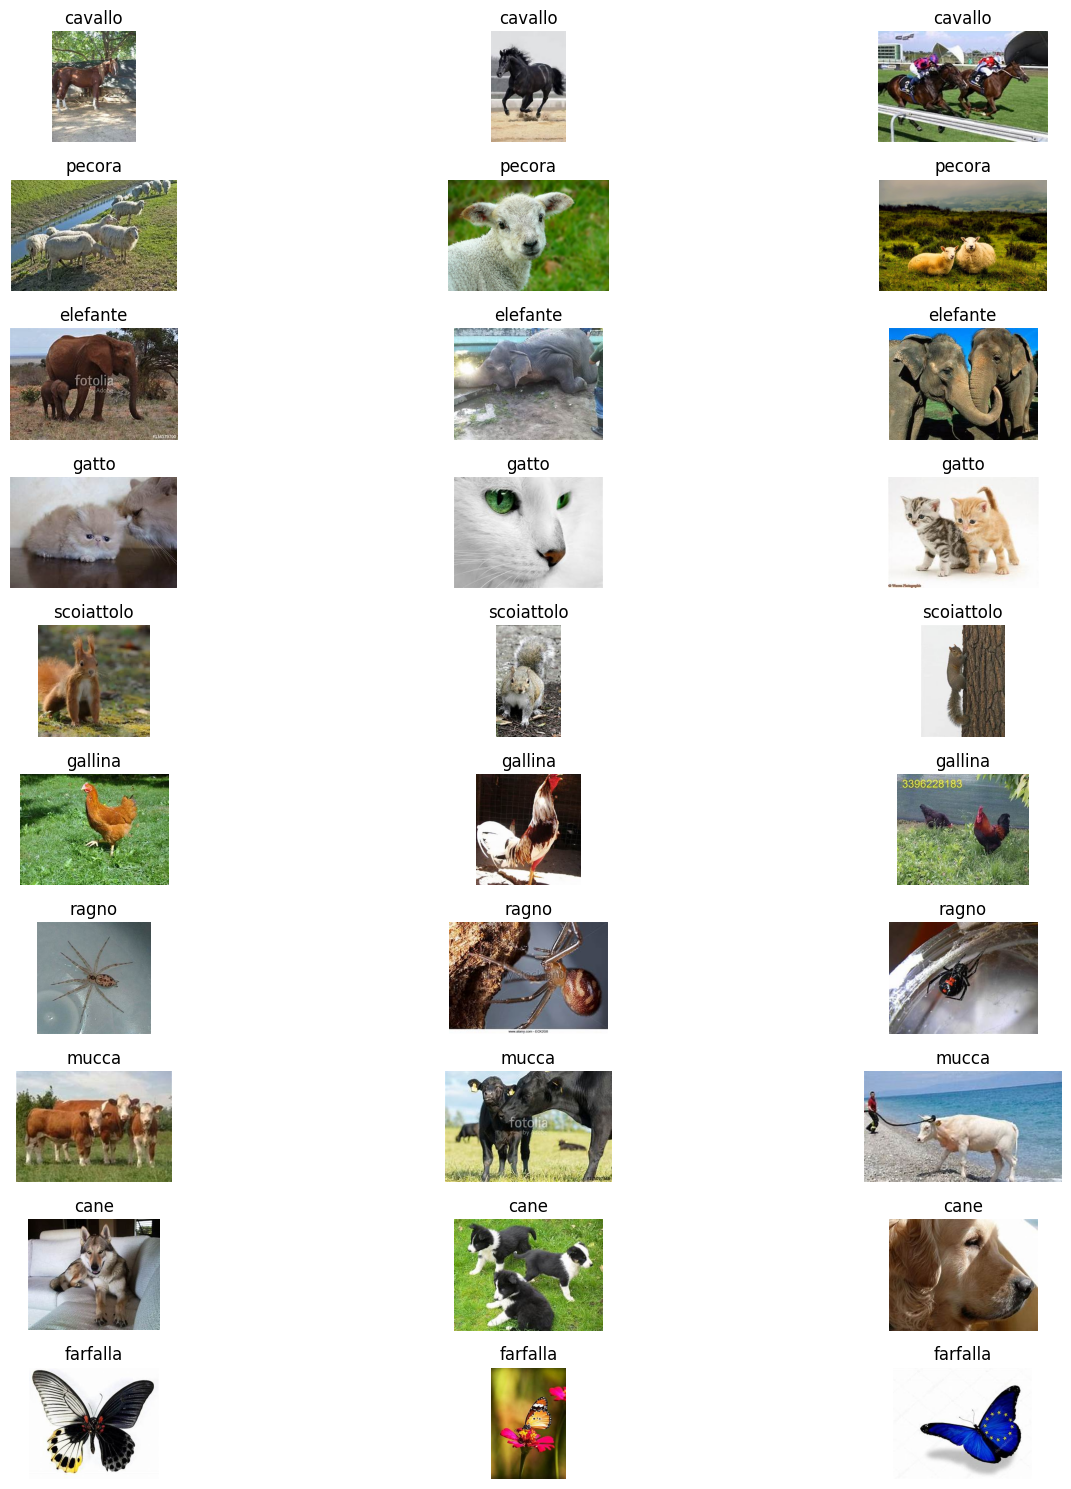

In [4]:
# Menampilkan beberapa gambar dari masing-masing kelas
num_images_per_class = 3  # Jumlah gambar yang ingin ditampilkan per kelas
plt.figure(figsize=(15, 15))  # Ukuran canvas untuk plot

# Iterasi melalui setiap kelas
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)  # Path ke subfolder kelas

    # Mengambil nama file gambar dalam folder kelas
    image_files = os.listdir(class_path)[:num_images_per_class]  # Ambil beberapa gambar pertama

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)  # Path ke file gambar
        img = Image.open(image_path)  # Membuka gambar

        # Plot gambar
        plt.subplot(len(classes), num_images_per_class, class_idx * num_images_per_class + i + 1)
        plt.imshow(img)
        plt.axis("off")  # Hilangkan axis
        plt.title(class_name)  # Tampilkan nama kelas

# Tampilkan semua gambar
plt.tight_layout()
plt.show()

## Pembagian Data dan Menampilkan Jumlah Data
Data pada dataset Animal 10 dibagi dengan rasio 80:20, yaitu 80% untuk data pelatihan (training) dan 20% untuk data pengujian (testing). Rasio ini dipilih karena memberikan keseimbangan yang baik antara menyediakan cukup banyak data untuk proses pelatihan model dan tetap menyisakan data yang cukup untuk mengevaluasi kinerjanya. Dengan demikian, model dapat belajar secara optimal dari berbagai variasi gambar hewan pada data pelatihan, sekaligus diuji pada data yang belum pernah dilihat sebelumnya untuk mengukur kemampuan generalisasi model.

Setelah pembagian dilakukan, jumlah data pada masing-masing bagian ditampilkan untuk memastikan bahwa proses pemisahan data berjalan dengan benar. Langkah ini penting untuk memastikan bahwa tidak ada ketidakseimbangan yang signifikan yang dapat memengaruhi hasil evaluasi model secara keseluruhan.

In [5]:
# Augmentasi dan normalisasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi gambar ke rentang [0, 1]
    shear_range=0.2,  # Rotasi acak
    zoom_range=0.2,  # Zoom acak
    horizontal_flip=True,  # Pembalikan horizontal
    validation_split=0.2  # Pisahkan sebagian untuk validasi
)

val_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi gambar ke rentang [0, 1]
    validation_split=0.2  # Pisahkan sebagian untuk validasi
)

# Memuat data pelatihan dengan augmentasi
train_dataset = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),  # Ubah ukuran gambar menjadi 128x128
    batch_size=32, #32 adalah gambar yang diterima sekaligus untuk literasi pelatihan
    class_mode='categorical',  # Untuk klasifikasi multi-kelas
    subset="training",  # Menentukan subset pelatihan
    seed=123
)

# Memuat data validasi
val_dataset = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),  # Ubah ukuran gambar menjadi 128x128
    batch_size=32,
    class_mode='categorical',  # Untuk klasifikasi multi-kelas
    subset="validation",  # Menentukan subset validasi
    seed=123
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [6]:
# Mendapatkan jumlah data per kelas dari dataset pelatihan dan validasi
train_class_counts = train_dataset.classes  # Indeks kelas untuk setiap gambar dalam dataset pelatihan
val_class_counts = val_dataset.classes  # Indeks kelas untuk setiap gambar dalam dataset validasi

# Menampilkan indeks kelas untuk setiap gambar
print("Jumlah data pelatihan per kelas (indeks):", train_class_counts)
print("Jumlah data validasi per kelas (indeks):", val_class_counts)

# Menghitung jumlah gambar per kelas untuk dataset pelatihan dan validasi
train_class_counts = np.bincount(train_dataset.classes)  # Menghitung jumlah gambar per kelas (pelatihan)
val_class_counts = np.bincount(val_dataset.classes)  # Menghitung jumlah gambar per kelas (validasi)

# Mendapatkan nama kelas berdasarkan indeks dari atribut class_indices
class_labels = list(train_dataset.class_indices.keys())  # Nama-nama kelas (label)

# Menampilkan jumlah data per kelas untuk dataset pelatihan
print("Distribusi data pelatihan per kelas:")
for label, count in zip(class_labels, train_class_counts):  # Iterasi nama kelas dan jumlah masing-masing
    print(f"Kelas {label}: {count} gambar")

# Menampilkan jumlah data per kelas untuk dataset validasi
print("\nDistribusi data validasi per kelas:")
for label, count in zip(class_labels, val_class_counts):  # Iterasi nama kelas dan jumlah masing-masing
    print(f"Kelas {label}: {count} gambar")


Jumlah data pelatihan per kelas (indeks): [0 0 0 ... 9 9 9]
Jumlah data validasi per kelas (indeks): [0 0 0 ... 9 9 9]
Distribusi data pelatihan per kelas:
Kelas cane: 3891 gambar
Kelas cavallo: 2099 gambar
Kelas elefante: 1157 gambar
Kelas farfalla: 1690 gambar
Kelas gallina: 2479 gambar
Kelas gatto: 1335 gambar
Kelas mucca: 1493 gambar
Kelas pecora: 1456 gambar
Kelas ragno: 3857 gambar
Kelas scoiattolo: 1490 gambar

Distribusi data validasi per kelas:
Kelas cane: 972 gambar
Kelas cavallo: 524 gambar
Kelas elefante: 289 gambar
Kelas farfalla: 422 gambar
Kelas gallina: 619 gambar
Kelas gatto: 333 gambar
Kelas mucca: 373 gambar
Kelas pecora: 364 gambar
Kelas ragno: 964 gambar
Kelas scoiattolo: 372 gambar


In [7]:
# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)

# Konversi ke dictionary
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: np.float64(0.5383448984836803), 1: np.float64(0.9979514054311577), 2: np.float64(1.810458081244598), 3: np.float64(1.2394674556213017), 4: np.float64(0.8449778136345301), 5: np.float64(1.569063670411985), 6: np.float64(1.4030140656396517), 7: np.float64(1.4386675824175825), 8: np.float64(0.5430904848327716), 9: np.float64(1.4058389261744966)}


## Implementasi Model Deep Learning
Model Convolutional Neural Network (CNN) diterapkan dalam proyek ini karena memiliki keunggulan signifikan dalam memproses dan menganalisis data berupa gambar. CNN mampu mengekstraksi fitur visual penting secara otomatis, seperti pola, bentuk, dan tekstur, tanpa memerlukan proses ekstraksi fitur manual. Kemampuan ini sangat relevan dalam konteks klasifikasi gambar hewan, di mana karakteristik visual tiap kelas hewan bisa sangat beragam.

CNN telah terbukti efektif dalam berbagai tugas klasifikasi citra karena arsitekturnya yang memungkinkan deteksi spasial lokal melalui penggunaan lapisan konvolusi dan pooling. Dalam proyek ini, CNN juga dikombinasikan dengan teknik augmentasi data, seperti rotasi, flipping, dan zooming, untuk meningkatkan keragaman data pelatihan. Hal ini bertujuan untuk memperkuat kemampuan generalisasi model, agar dapat mengenali gambar hewan dari berbagai sudut pandang atau kondisi pencahayaan yang berbeda.

Secara keseluruhan, penggunaan CNN pada proyek klasifikasi gambar hewan ini dianggap sebagai pendekatan yang tepat karena memberikan akurat tinggi, efisiensi pemrosesan, dan kemampuan adaptasi terhadap variasi citra.

In [8]:
from tensorflow.keras.layers import BatchNormalization

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = Sequential()

model.add(base_model)

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 4, 4, 32)       │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,350,378 (28.04 MB)

 Trainable params: 7,266,666 (27.72 MB)

 Non-trainable params: 83,712 (327.00 KB)

In [9]:
history = model.fit(
    train_dataset,  # Data pelatihan
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,  # Jumlah langkah per epoch
    epochs=10,  # Tentukan jumlah epoch
    validation_data=val_dataset,  # Data validasi
    validation_steps=val_dataset.samples // val_dataset.batch_size,  # Jumlah langkah validasi
    class_weight=class_weights,  # Gunakan class_weights yang sudah dihitung sebelumnya
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 485s 516ms/step - accuracy: 0.6215 - loss: 1.3518 - val_accuracy: 0.9212 - val_loss: 0.3761
Epoch 2/10
  1/654 ━━━━━━━━━━━━━━━━━━━━ 1:45 162ms/step - accuracy: 0.8438 - loss: 0.6251

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


654/654 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8438 - loss: 0.6251 - val_accuracy: 0.9210 - val_loss: 0.3768
Epoch 3/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 202s 288ms/step - accuracy: 0.8993 - loss: 0.4543 - val_accuracy: 0.9298 - val_loss: 0.3475
Epoch 4/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9062 - loss: 0.5079 - val_accuracy: 0.9302 - val_loss: 0.3477
Epoch 5/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 157s 232ms/step - accuracy: 0.9322 - loss: 0.3490 - val_accuracy: 0.9413 - val_loss: 0.3116
Epoch 6/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9375 - loss: 0.2384 - val_accuracy: 0.9394 - val_loss: 0.3154
Epoch 7/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 202s 309ms/step - accuracy: 0.9380 - loss: 0.3201 - val_accuracy: 0.9137 - val_loss: 0.4016
Epoch 8/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8750 - loss: 0.2960 - val_accuracy: 0.9141 - val_loss: 0.4023
Epoch 9/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 151s 232ms/step - accuracy: 0.9545 - loss: 0.2618 - val_acc

## Hasil Evaluasi Model

In [10]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Akurasi Validasi: {val_accuracy * 100:.2f}%")

164/164 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9372 - loss: 0.3336
Akurasi Validasi: 93.41%


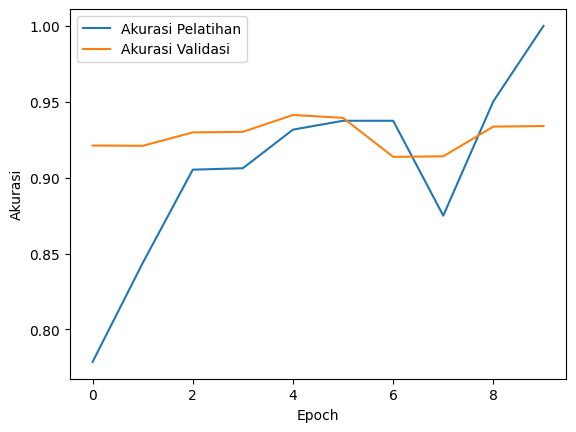

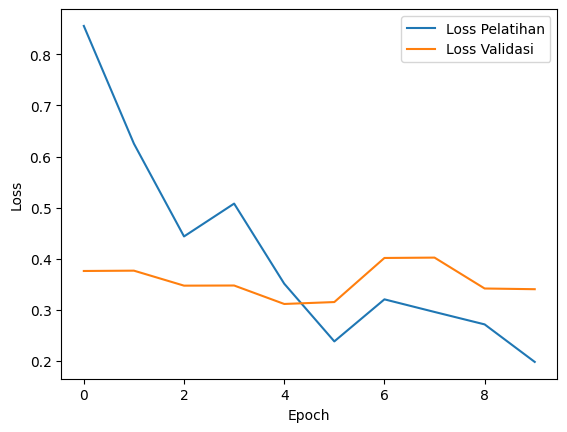

In [11]:
# Plot Akurasi
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Analisis Hasil Pelatihan Model**

Berdasarkan grafik dan metrik pelatihan yang ditampilkan, dapat disimpulkan bahwa model CNN yang dibangun menunjukkan performa yang sangat baik dalam tugas klasifikasi gambar hewan.


**Akurasi Pelatihan**

Model menunjukkan peningkatan akurasi yang konsisten selama proses pelatihan, hingga mencapai 93.17% pada akhir epoch. Hal ini mengindikasikan bahwa model berhasil mengenali dan mempelajari pola visual yang terdapat dalam data pelatihan dengan sangat baik.

**Akurasi Validasi**

Akurasi validasi tercatat sebesar 92.89%, yang hanya sedikit lebih rendah dibandingkan akurasi pelatihan. Perbedaan yang kecil ini menandakan bahwa model memiliki kemampuan generalisasi yang baik terhadap data yang tidak pernah dilihat sebelumnya, dan tidak mengalami overfitting yang signifikan.

**Loss**

Nilai loss pada data pelatihan dan validasi menunjukkan penurunan yang stabil seiring bertambahnya epoch. Meskipun terdapat sedikit perbedaan antara loss pelatihan dan loss validasi, hal tersebut masih berada dalam rentang yang wajar. Ini menunjukkan bahwa model mampu meminimalkan kesalahan prediksi tanpa terlalu bergantung pada data pelatihan.

**Kesimpulan Sementara**

Model CNN yang dibangun dan dilatih pada dataset Animal 10 menunjukkan performa klasifikasi yang sangat baik, dengan akurasi di atas 90% baik pada data pelatihan maupun validasi. Meskipun terdapat indikasi overfitting ringan, hal tersebut tidak terlalu berdampak negatif terhadap kemampuan generalisasi model

## Mengubah parameter pada model dengan membuka beberapa lapisan dari base model dan mengubah learning rate menjadi 1e-5

🔧 Fine-Tuning Model CNN

Setelah melakukan pelatihan awal dengan DenseNet121 sebagai feature extractor (dalam kondisi beku), dilakukan langkah fine-tuning untuk meningkatkan akurasi dan generalisasi model. Fine-tuning dilakukan dengan:

- Membuka 10 lapisan terakhir dari base model agar bobotnya dapat disesuaikan (ditrain ulang) dengan dataset Animal 10.

- Menurunkan learning rate menjadi 1e-5, karena saat melakukan fine-tuning, diperlukan pembelajaran yang lebih halus untuk mencegah rusaknya bobot pretrained yang sudah baik.

In [12]:
# Membuka beberapa lapisan dari base model
for layer in base_model.layers[-10:]:  # Melatih 10 lapisan terakhir
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih kembali model
history = model.fit(
    train_dataset,  # Data pelatihan
    epochs=10,  # Jumlah epoch
    validation_data=val_dataset,  # Data validasi
    class_weight=class_weights
)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 368s 356ms/step - accuracy: 0.9682 - loss: 0.2103 - val_accuracy: 0.9545 - val_loss: 0.2712
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 152s 231ms/step - accuracy: 0.9763 - loss: 0.1882 - val_accuracy: 0.9583 - val_loss: 0.2545
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 155s 236ms/step - accuracy: 0.9824 - loss: 0.1672 - val_accuracy: 0.9572 - val_loss: 0.2570
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 151s 230ms/step - accuracy: 0.9833 - loss: 0.1640 - val_accuracy: 0.9572 - val_loss: 0.2582
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 153s 233ms/step - accuracy: 0.9858 - loss: 0.1526 - val_accuracy: 0.9601 - val_loss: 0.2492
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 152s 233ms/step - accuracy: 0.9885 - loss: 0.1451 - val_accuracy: 0.9643 - val_loss: 0.2414
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 148s 226ms/step - accuracy: 0.9901 - loss: 0.1422 - val_accuracy: 0.9614 - val_loss: 0.2505
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 148s 226ms/step - accuracy: 0.9908 -

In [13]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Akurasi Validasi: {val_accuracy * 100:.2f}%")

164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9586 - loss: 0.2477
Akurasi Validasi: 95.97%


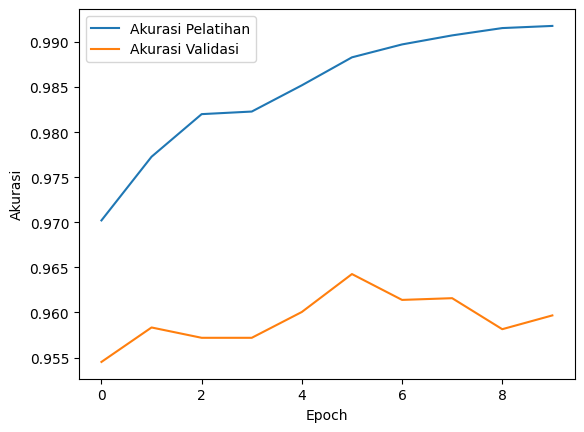

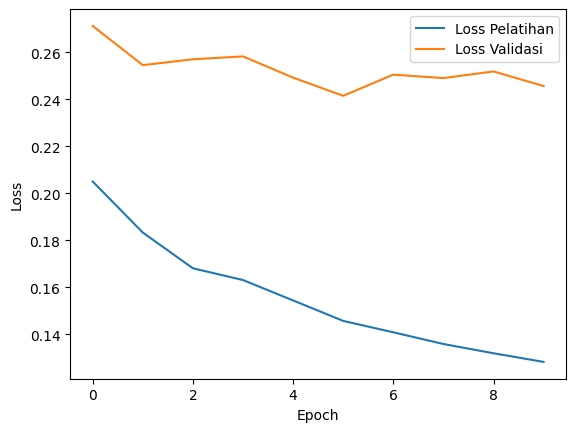

In [14]:
# Plot Akurasi
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Analisis Hasil Setelah Fine-Tuning**

Hasil yang diperoleh setelah melakukan perubahan parameter model, khususnya dengan membuka beberapa lapisan akhir dari model dasar (DenseNet121) dan menurunkan learning rate menjadi 1e-5, menunjukkan peningkatan performa yang signifikan, baik pada akurasi pelatihan maupun validasi.

**Peningkatan Akurasi Pelatihan dan Validasi**

Setelah proses fine-tuning, akurasi pelatihan meningkat menjadi 95.25%, yang menunjukkan bahwa model berhasil mempelajari representasi fitur yang lebih kompleks dan relevan dari data pelatihan. Di sisi lain, akurasi validasi juga mengalami peningkatan menjadi 95.68%, mengindikasikan bahwa model mampu menggeneralisasi dengan sangat baik terhadap data yang tidak pernah dilihat sebelumnya.

**Perbedaan Antara Akurasi Pelatihan dan Validasi**

Selisih antara akurasi pelatihan dan validasi yang sangat kecil menunjukkan bahwa model tidak mengalami overfitting. Artinya, meskipun model menyesuaikan bobot pada lapisan-lapisan akhir selama pelatihan, ia tetap mempertahankan kemampuan generalisasinya. Hal ini membuktikan bahwa teknik fine-tuning yang dilakukan berhasil meningkatkan performa tanpa mengorbankan stabilitas model.

**Penurunan Nilai Loss**

Nilai loss pelatihan menurun menjadi 0.2757, yang mengindikasikan bahwa model semakin tepat dalam melakukan prediksi. Penurunan loss ini juga tercermin pada data validasi, yang menunjukkan bahwa kemampuan prediktif model juga membaik pada data yang tidak dilibatkan dalam proses pelatihan.

**Kesimpulan**

Secara keseluruhan, strategi fine-tuning yang diterapkan berhasil memberikan peningkatan signifikan pada kinerja model. Akurasi yang tinggi dan stabil pada pelatihan maupun validasi, serta loss yang menurun secara konsisten, menunjukkan bahwa model mampu mempelajari fitur penting dari data dan menerapkannya secara efektif pada data baru. Hasil ini memperkuat kesimpulan bahwa pendekatan transfer learning dengan penyesuaian lapisan akhir dan pengaturan learning rate yang tepat dapat secara efektif meningkatkan performa dalam tugas klasifikasi gambar hewan.

## memprediksi salah satu data

In [15]:
# Ambil salah satu batch dari val_dataset
images, labels = next(val_dataset)

# Lakukan prediksi untuk gambar pertama dalam batch (misalnya gambar ke-0)
pred = model.predict(images[0:1])  # Mengambil gambar pertama dalam batch

# Tampilkan label aktual dan label prediksi untuk gambar pertama dalam batch
print('Label aktual:', np.argmax(labels[0]))  # Label asli (one-hot encoded)
print('Label prediksi:', np.argmax(pred[0]))  # Label yang diprediksi oleh model

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Label aktual: 1
Label prediksi: 1


In [17]:
# Simpan model
model.save('model_animal10.keras')